In [1]:
import pandas as pd
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score, f1_score, matthews_corrcoef

from sklearn.ensemble import ExtraTreesClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from joblib import dump

import warnings
warnings.filterwarnings("ignore")

## Training ExtraTreesClassifier with prottrans_t5_uniref

In [2]:
df_data = pd.read_csv("../../selected_strategies/single_double/prottrans_t5_uniref.csv")

df_positive = df_data[df_data["type_interaction"] == "single"]
df_positive["type_interaction"] = 1

df_negative = df_data[df_data["type_interaction"] == "double"]
df_negative["type_interaction"] = 0

df_data_negative_shuffle = shuffle(df_negative, random_state=42)
df_data_negative_to_train = df_data_negative_shuffle[:len(df_positive)]

df_to_train = pd.concat([df_positive, df_data_negative_to_train], axis=0)

response = df_to_train["type_interaction"]
df_to_train = df_to_train.drop(columns=["type_interaction"])

X_train, X_test, y_train, y_test = train_test_split(df_to_train, response, random_state=42, test_size=0.3)

extra_tree_model = ExtraTreesClassifier(
    n_estimators=3346,
    criterion='log_loss',
    min_samples_split=2,
    min_samples_leaf=1, 
    max_features='sqrt'
)

extra_tree_model.fit(X=X_train, y=y_train)
y_pred = extra_tree_model.predict(X=X_test)

test_accuracy = accuracy_score(y_true=y_test, y_pred=y_pred)
test_precision = f1_score(y_true=y_test, y_pred=y_pred)
test_f1 = precision_score(y_true=y_test, y_pred=y_pred)
test_recall = recall_score(y_true=y_test, y_pred=y_pred)
test_mcc = matthews_corrcoef(y_true=y_test, y_pred=y_pred)
test_cm = confusion_matrix(y_test, y_pred).tolist()

columns = ["Algorithm", "Encoder", "test_accuracy", "test_precision", "test_f1", "test_recall", "test_mcc", "test_cm"]
row = [["ExtraTreesClassifier", "prottrans_t5_uniref", test_accuracy, test_precision, test_f1, test_recall, test_mcc, test_cm]]
df1 = pd.DataFrame(columns=columns, data= row)
print(df1)

              Algorithm              Encoder  test_accuracy  test_precision  \
0  ExtraTreesClassifier  prottrans_t5_uniref        0.89441        0.881119   

    test_f1  test_recall  test_mcc              test_cm  
0  0.940299     0.828947  0.791881  [[81, 4], [13, 63]]  


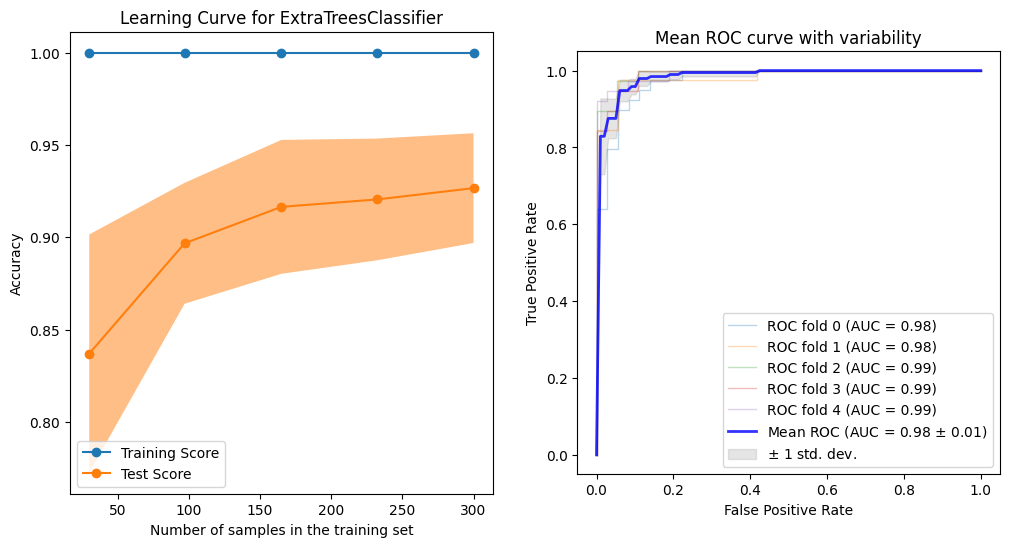

In [3]:
from sklearn.metrics import RocCurveDisplay, auc
from sklearn.model_selection import StratifiedKFold
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import LearningCurveDisplay, ShuffleSplit

fig, ax = plt.subplots(1,2, figsize=(12, 6))

common_params = {
    "X": X_train,
    "y": y_train,
    "train_sizes": np.linspace(0.1, 1.0, 5),
    "cv": ShuffleSplit(n_splits=50, test_size=0.2, random_state=0),
    "score_type": "both",
    "n_jobs": 12,
    "line_kw": {"marker": "o"},
    "std_display_style": "fill_between",
    "score_name": "Accuracy",
}

LearningCurveDisplay.from_estimator(extra_tree_model, **common_params, ax=ax[0])
handles, label = ax[0].get_legend_handles_labels()
ax[0].legend(handles[:2], ["Training Score", "Test Score"])
ax[0].set_title(f"Learning Curve for {extra_tree_model.__class__.__name__}")

#######################################################################################
n_splits = 5
cv = StratifiedKFold(n_splits=n_splits)

tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

for fold, (train, test) in enumerate(cv.split(X_train, y_train)):
    extra_tree_model.fit(X_train.values[train], y_train.values[train])
    viz = RocCurveDisplay.from_estimator(
        extra_tree_model,
        X_train.values[test],
        y_train.values[test],
        name=f"ROC fold {fold}",
        alpha=0.3,
        lw=1,
        ax=ax[1]
    )
    interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(viz.roc_auc)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)

ax[1].plot(
    mean_fpr,
    mean_tpr,
    color="b",
    label=r"Mean ROC (AUC = %0.2f $\pm$ %0.2f)" % (mean_auc, std_auc),
    lw=2,
    alpha=0.8,
)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)

ax[1].fill_between(
    mean_fpr,
    tprs_lower,
    tprs_upper,
    color="grey",
    alpha=0.2,
    label=r"$\pm$ 1 std. dev.",
)

ax[1].set(
    xlim=[-0.05, 1.05],
    ylim=[-0.05, 1.05],
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
    title=f"Mean ROC curve with variability",
)
ax[1].axis("square")
ax[1].legend(loc="lower right")

plt.show()

In [13]:
name_export = "../../trained_models/single_double/ExtraTreesClassifier_prottrans_t5_uniref.joblib"
dump(extra_tree_model, name_export)

['../../trained_models/single_double/ExtraTreesClassifier_prottrans_t5_uniref.joblib']

### Training models with prottrans_t5_xlu50

In [5]:
df_data = pd.read_csv("../../selected_strategies/single_double/prottrans_t5_xlu50.csv")

df_positive = df_data[df_data["type_interaction"] == "single"]
df_positive["type_interaction"] = 1

df_negative = df_data[df_data["type_interaction"] == "double"]
df_negative["type_interaction"] = 0

df_data_negative_shuffle = shuffle(df_negative, random_state=42)
df_data_negative_to_train = df_data_negative_shuffle[:len(df_positive)]

df_to_train = pd.concat([df_positive, df_data_negative_to_train], axis=0)

response = df_to_train["type_interaction"]
df_to_train = df_to_train.drop(columns=["type_interaction"])

X_train, X_test, y_train, y_test = train_test_split(df_to_train, response, random_state=42, test_size=0.3)


### Training extra-tree

In [6]:
extra_tree_model_2 = ExtraTreesClassifier(
    n_estimators=34,
    criterion='log_loss',
    min_samples_split=2,
    min_samples_leaf=2, 
    max_features='sqrt'
)

extra_tree_model_2.fit(X=X_train, y=y_train)
y_pred = extra_tree_model_2.predict(X=X_test)

test_accuracy = accuracy_score(y_true=y_test, y_pred=y_pred)
test_precision = f1_score(y_true=y_test, y_pred=y_pred)
test_f1 = precision_score(y_true=y_test, y_pred=y_pred)
test_recall = recall_score(y_true=y_test, y_pred=y_pred)
test_mcc = matthews_corrcoef(y_true=y_test, y_pred=y_pred)
test_cm = confusion_matrix(y_test, y_pred).tolist()

columns = ["Algorithm", "Encoder", "test_accuracy", "test_precision", "test_f1", "test_recall", "test_mcc", "test_cm"]
row = [["ExtraTreesClassifier", "prottrans_t5_xlu50", test_accuracy, test_precision, test_f1, test_recall, test_mcc, test_cm]]
df2 = pd.DataFrame(columns=columns, data= row)
print(df2)

              Algorithm             Encoder  test_accuracy  test_precision  \
0  ExtraTreesClassifier  prottrans_t5_xlu50       0.900621        0.888889   

    test_f1  test_recall  test_mcc              test_cm  
0  0.941176     0.842105   0.80355  [[81, 4], [12, 64]]  


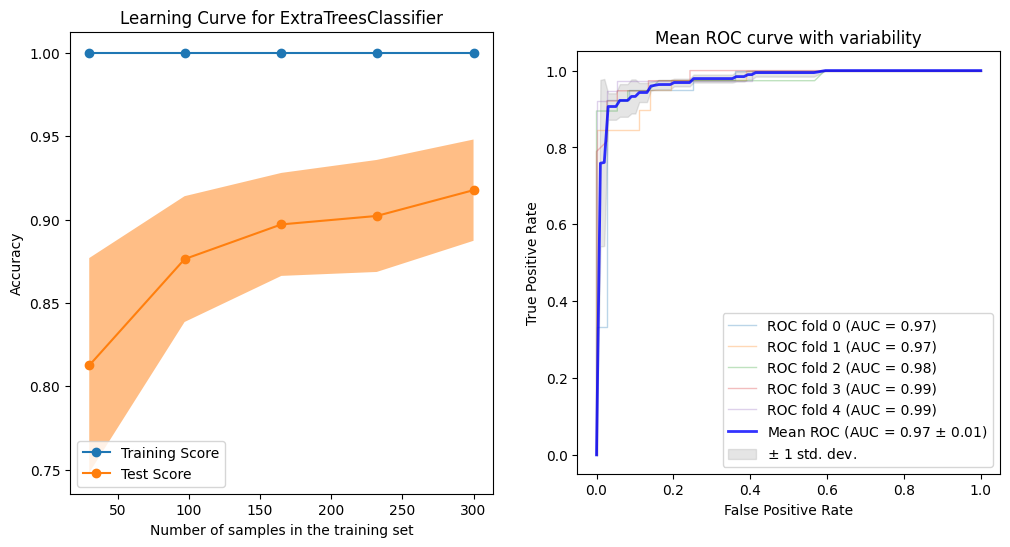

In [7]:
fig, ax = plt.subplots(1,2, figsize=(12, 6))

common_params = {
    "X": X_train,
    "y": y_train,
    "train_sizes": np.linspace(0.1, 1.0, 5),
    "cv": ShuffleSplit(n_splits=50, test_size=0.2, random_state=0),
    "score_type": "both",
    "n_jobs": 12,
    "line_kw": {"marker": "o"},
    "std_display_style": "fill_between",
    "score_name": "Accuracy",
}

LearningCurveDisplay.from_estimator(extra_tree_model_2, **common_params, ax=ax[0])
handles, label = ax[0].get_legend_handles_labels()
ax[0].legend(handles[:2], ["Training Score", "Test Score"])
ax[0].set_title(f"Learning Curve for {extra_tree_model_2.__class__.__name__}")

#######################################################################################
n_splits = 5
cv = StratifiedKFold(n_splits=n_splits)

tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

for fold, (train, test) in enumerate(cv.split(X_train, y_train)):
    extra_tree_model_2.fit(X_train.values[train], y_train.values[train])
    viz = RocCurveDisplay.from_estimator(
        extra_tree_model_2,
        X_train.values[test],
        y_train.values[test],
        name=f"ROC fold {fold}",
        alpha=0.3,
        lw=1,
        ax=ax[1]
    )
    interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(viz.roc_auc)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)

ax[1].plot(
    mean_fpr,
    mean_tpr,
    color="b",
    label=r"Mean ROC (AUC = %0.2f $\pm$ %0.2f)" % (mean_auc, std_auc),
    lw=2,
    alpha=0.8,
)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)

ax[1].fill_between(
    mean_fpr,
    tprs_lower,
    tprs_upper,
    color="grey",
    alpha=0.2,
    label=r"$\pm$ 1 std. dev.",
)

ax[1].set(
    xlim=[-0.05, 1.05],
    ylim=[-0.05, 1.05],
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
    title=f"Mean ROC curve with variability",
)
ax[1].axis("square")
ax[1].legend(loc="lower right")

plt.show()

In [14]:
name_export = "../../trained_models/single_double/ExtraTreesClassifier_prottrans_t5_xlu50.joblib"
dump(extra_tree_model_2, name_export)

['../../trained_models/single_double/ExtraTreesClassifier_prottrans_t5_xlu50.joblib']

### Gaussian Process

In [12]:
gaussian_process = GaussianProcessClassifier(
    n_restarts_optimizer=1,
    max_iter_predict=351
)

gaussian_process.fit(X=X_train, y=y_train)
y_pred = gaussian_process.predict(X=X_test)

test_accuracy = accuracy_score(y_true=y_test, y_pred=y_pred)
test_precision = f1_score(y_true=y_test, y_pred=y_pred)
test_f1 = precision_score(y_true=y_test, y_pred=y_pred)
test_recall = recall_score(y_true=y_test, y_pred=y_pred)
test_mcc = matthews_corrcoef(y_true=y_test, y_pred=y_pred)
test_cm = confusion_matrix(y_test, y_pred).tolist()

columns = ["Algorithm", "Encoder", "test_accuracy", "test_precision", "test_f1", "test_recall", "test_mcc", "test_cm"]
row = [["GaussianProcessClassifier", "prottrans_t5_xlu50", test_accuracy, test_precision, test_f1, test_recall, test_mcc, test_cm]]
df3 = pd.DataFrame(columns=columns, data= row)
print(df3)

name_export = "../../trained_models/single_double/GaussianProcessClassifier_prottrans_t5_xlu50.joblib"
dump(gaussian_process, name_export)

                   Algorithm             Encoder  test_accuracy  \
0  GaussianProcessClassifier  prottrans_t5_xlu50        0.89441   

   test_precision   test_f1  test_recall  test_mcc              test_cm  
0        0.881119  0.940299     0.828947  0.791881  [[81, 4], [13, 63]]  


['../../trained_models/single_double/GaussianProcessClassifier_prottrans_t5_xlu50.joblib']

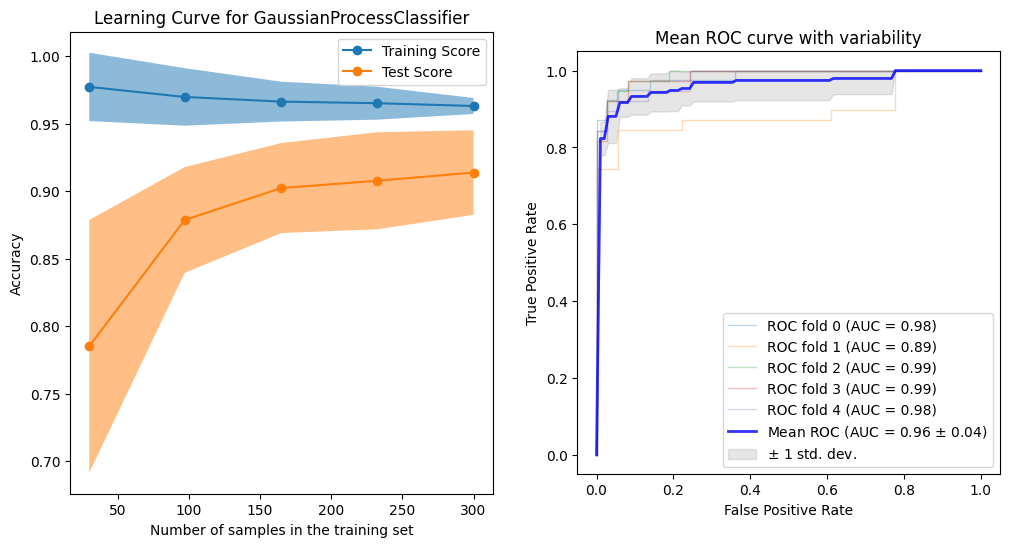

In [10]:
fig, ax = plt.subplots(1,2, figsize=(12, 6))

common_params = {
    "X": X_train,
    "y": y_train,
    "train_sizes": np.linspace(0.1, 1.0, 5),
    "cv": ShuffleSplit(n_splits=50, test_size=0.2, random_state=0),
    "score_type": "both",
    "n_jobs": 12,
    "line_kw": {"marker": "o"},
    "std_display_style": "fill_between",
    "score_name": "Accuracy",
}

LearningCurveDisplay.from_estimator(gaussian_process, **common_params, ax=ax[0])
handles, label = ax[0].get_legend_handles_labels()
ax[0].legend(handles[:2], ["Training Score", "Test Score"])
ax[0].set_title(f"Learning Curve for {gaussian_process.__class__.__name__}")

#######################################################################################
n_splits = 5
cv = StratifiedKFold(n_splits=n_splits)

tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

for fold, (train, test) in enumerate(cv.split(X_train, y_train)):
    gaussian_process.fit(X_train.values[train], y_train.values[train])
    viz = RocCurveDisplay.from_estimator(
        gaussian_process,
        X_train.values[test],
        y_train.values[test],
        name=f"ROC fold {fold}",
        alpha=0.3,
        lw=1,
        ax=ax[1]
    )
    interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(viz.roc_auc)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)

ax[1].plot(
    mean_fpr,
    mean_tpr,
    color="b",
    label=r"Mean ROC (AUC = %0.2f $\pm$ %0.2f)" % (mean_auc, std_auc),
    lw=2,
    alpha=0.8,
)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)

ax[1].fill_between(
    mean_fpr,
    tprs_lower,
    tprs_upper,
    color="grey",
    alpha=0.2,
    label=r"$\pm$ 1 std. dev.",
)

ax[1].set(
    xlim=[-0.05, 1.05],
    ylim=[-0.05, 1.05],
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
    title=f"Mean ROC curve with variability",
)
ax[1].axis("square")
ax[1].legend(loc="lower right")

plt.show()

In [11]:
df_full = pd.concat([df1, df2, df3], axis=0)
df_full

,Algorithm,Encoder,test_accuracy,test_precision,test_f1,test_recall,test_mcc,test_cm
0,ExtraTreesClassifier,prottrans_t5_uniref,0.894410,0.881119,0.940299,0.828947,0.791881,"[[81, 4], [13, 63]]"
0,ExtraTreesClassifier,prottrans_t5_xlu50,0.900621,0.888889,0.941176,0.842105,0.803550,"[[81, 4], [12, 64]]"
0,GaussianProcessClassifier,prottrans_t5_xlu50,0.894410,0.881119,0.940299,0.828947,0.791881,"[[81, 4], [13, 63]]"
